## Mongobch results

### Deployment
Mongodb - Free cluster tier on MongoDB Atlas: M0 (Shared RAM, 512 MB Storage, 3 nodes, AWS, Frankfurt eu-central-1)

mongobch.py run on t2.nano AWS, Frankfurt (eu-central-1)


In [47]:
usePackage <- function(p) {
  if (!is.element(p, installed.packages()[,1]))
    install.packages(p, dep = TRUE)
  require(p, character.only = TRUE, quietly = TRUE)
}

usePackage("data.table") 
usePackage("ggplot2")
usePackage("plyr")

Sys.setlocale("LC_TIME", "us")

options(stringsAsFactors = FALSE)

[1] "English_United States.1252"

In [48]:
raw <- fread('grep Thread ..\\logs\\aws_atlas_bench_June_01*', 
             sep=",", 
             col.names=c("time", "response_time", "case", "thread", "label"))


tidy <- data.table(raw, do.call(rbind, strsplit(raw$label,"-")))

setnames(tidy, "V1", "deployment")
setnames(tidy, "V2", "posts_num")
setnames(tidy, "V3", "thread_num")


tidy$thread_num <- as.numeric(tidy$thread_num)
tidy$posts_num <- as.numeric(tidy$posts_num)

#tidy$time <- as.POSIXct(sapply(strsplit(tidy$time, ":"), function(x){ paste(x[2:4], collapse=":")}), tz="", format="%Y-%m-%d %H:%M:%OS")
tidy$time <- as.POSIXct(tidy$time, tz="", format="%Y-%m-%d %H:%M:%OS")

head(tidy)
tail(tidy)

time,response_time,case,thread,label,deployment,posts_num,thread_num
2018-06-01 14:39:44,0.00000000,started,Thread-0,aws-100000-5,aws,1e+05,5
2018-06-01 14:39:44,0.00000000,started,Thread-1,aws-100000-5,aws,1e+05,5
2018-06-01 14:39:44,0.00000000,started,Thread-2,aws-100000-5,aws,1e+05,5
2018-06-01 14:39:44,0.06669831,read,Thread-0,aws-100000-5,aws,1e+05,5
2018-06-01 14:39:44,0.00000000,started,Thread-3,aws-100000-5,aws,1e+05,5
2018-06-01 14:39:44,0.06143308,upvote,Thread-1,aws-100000-5,aws,1e+05,5


time,response_time,case,thread,label,deployment,posts_num,thread_num
2018-06-01 14:48:37,0.001680851,upvote,Thread-15,aws-400000-40,aws,4e+05,40
2018-06-01 14:48:37,0.001535892,comment,Thread-15,aws-400000-40,aws,4e+05,40
2018-06-01 14:48:37,0.001555204,read,Thread-15,aws-400000-40,aws,4e+05,40
2018-06-01 14:48:37,0.001481295,read,Thread-15,aws-400000-40,aws,4e+05,40
2018-06-01 14:48:37,0.001516819,read,Thread-15,aws-400000-40,aws,4e+05,40
2018-06-01 14:48:37,67.996090412,finished,Thread-15,aws-400000-40,aws,4e+05,40


## Response time during tests

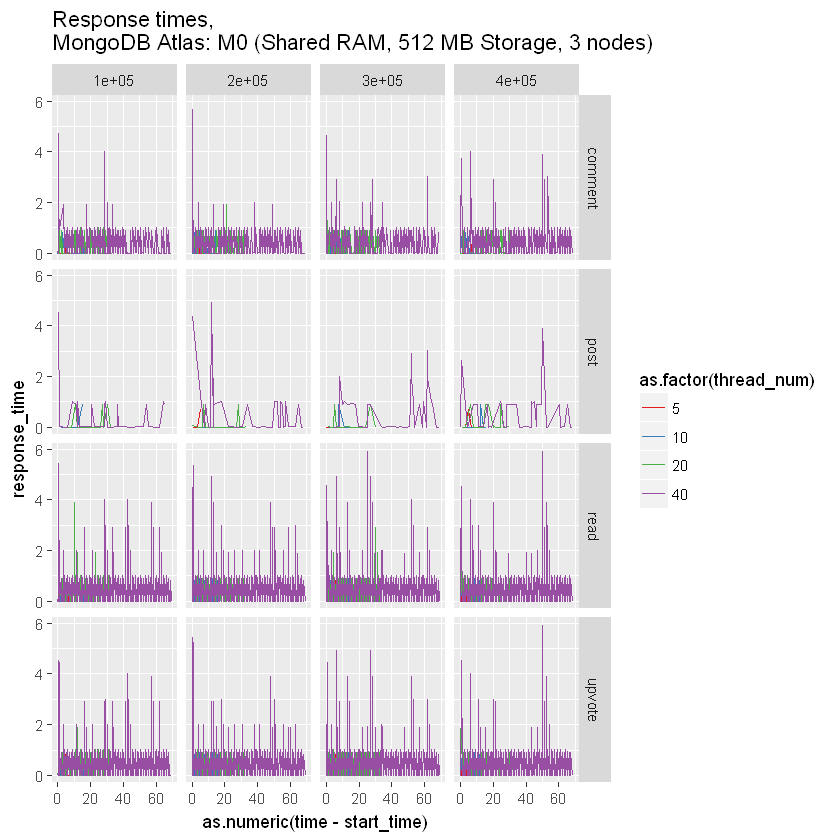

In [49]:
  ggplot(data = join(tidy, tidy[, list(start_time=min(time)), by="label"], by="label")[case != "finished"][case != "started"], 
         aes(x=as.numeric(time - start_time),
             y=response_time,  
             colour=as.factor(thread_num))) + ylim(0,NA) +  
    scale_color_brewer(palette="Set1") + facet_grid( case ~ as.factor(posts_num))+ 
    geom_line(size=0.5) + ggtitle(paste0("Response times, \nMongoDB Atlas: M0 (Shared RAM, 512 MB Storage, 3 nodes) ")) 

### Response time for "Post" case on different workloads
It depends on size of the response, which grows during test run.

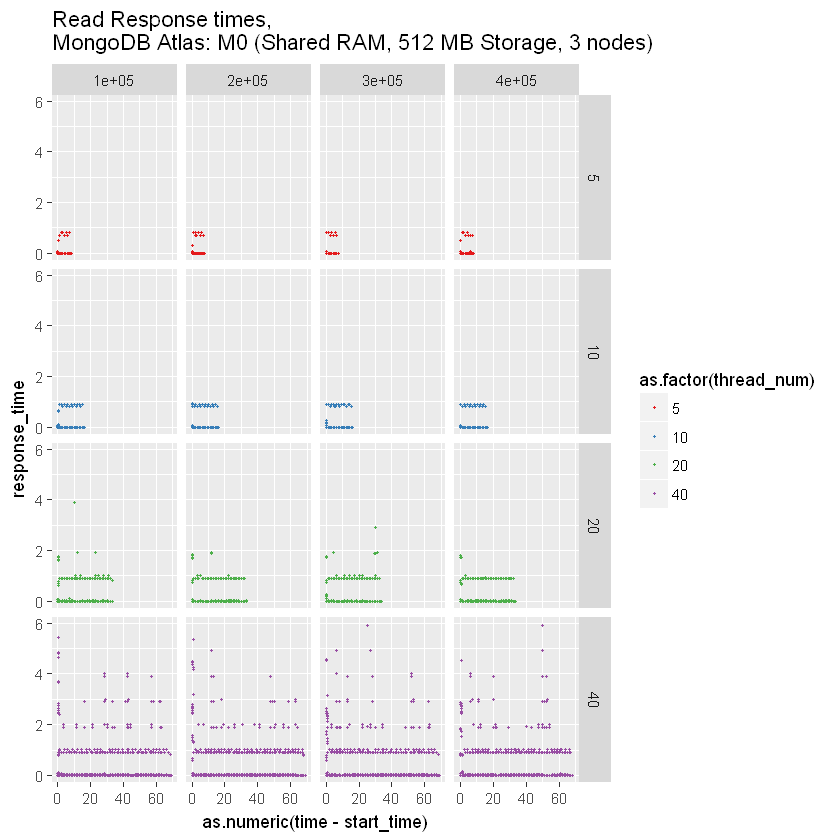

In [50]:
  ggplot(data = join(tidy, tidy[, list(start_time=min(time)), by="label"], by="label")[case == "read"], 
         aes(x=as.numeric(time - start_time),
             y=response_time,  
             colour=as.factor(thread_num))) + ylim(0,NA) +  
    scale_color_brewer(palette="Set1") + facet_grid( as.factor(thread_num) ~ as.factor(posts_num))+ 
    geom_point(size=0.5) + 
    ggtitle(paste0("Read Response times, \nMongoDB Atlas: M0 (Shared RAM, 512 MB Storage, 3 nodes) ")) 

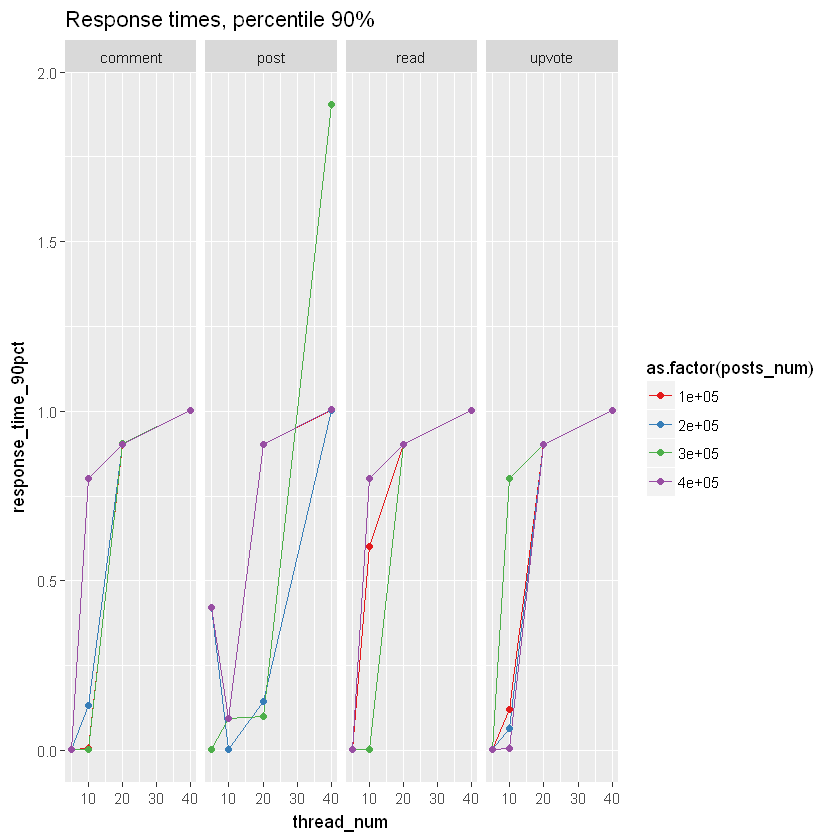

In [51]:
 ggplot(data = tidy[case != "finished"][case != "started"][,list(response_time_90pct = quantile(response_time, 0.9)), by="case,thread_num,posts_num"], 
         aes(x=thread_num, 
             y=response_time_90pct, 
             group=as.factor(posts_num), 
             colour=as.factor(posts_num))) + ylim(0,NA)+ scale_color_brewer(palette="Set1") + facet_grid( . ~ case ) + 
    geom_line() + geom_point()+ ggtitle(paste0("Response times, percentile 90%")) 

### Duting tests replication on secondary nodes was about 7 minutes late

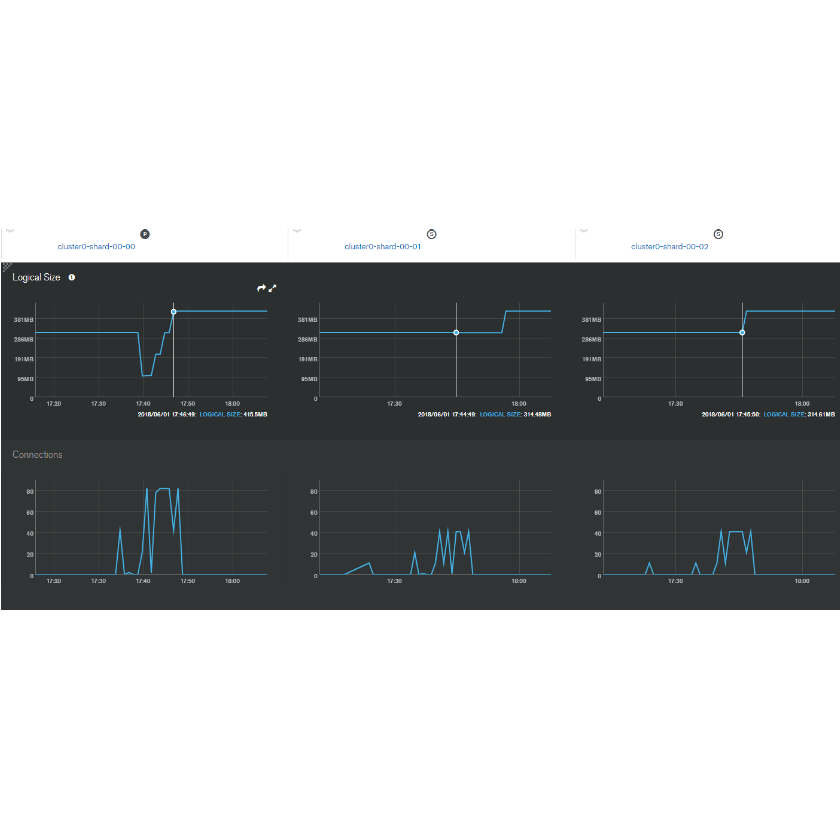

In [52]:
usePackage("png")
img <- readPNG("cluster_monitoring_June_01.png")
grid::grid.raster(img)